# Определение стоимости автомобилей

Готовим модель для сервиса по продаже автомобилей. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены. Попробуем построить модель, которая будет быстро и с высокой точностью предсказывать рыночную стоимость автомобиля. 

Сравним качество предсказания (будем использовать RMSE), скорость предсказания и время обучения для разных моделей.  Рассмотрим константную модель, линейную регрессию и градиентный бустинг (CatBoost, LightGBM).

Признаки
* *DateCrawled* — дата скачивания анкеты из базы
* *VehicleType* — тип автомобильного кузова
* *RegistrationYear* — год регистрации автомобиля
* *Gearbox* — тип коробки передач
* *Power* — мощность (л. с.)
* *Model* — модель автомобиля
* *Kilometer* — пробег (км)
* *RegistrationMonth* — месяц регистрации автомобиля
* *FuelType* — тип топлива
* *Brand* — марка автомобиля
* *NotRepaired* — была машина в ремонте или нет
* *DateCreated* — дата создания анкеты
* *NumberOfPictures* — количество фотографий автомобиля
* *PostalCode* — почтовый индекс владельца анкеты (пользователя)
* *LastSeen* — дата последней активности пользователя  

Целевой признак
* *Price* — цена (евро)


In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import time

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Подготовка данных

### Знакомство с данными

In [2]:
df = pd.read_csv('/datasets/autos.csv')
display(f'Размер датафрейма: {len(df)} строк, {len(df.columns)} столбцов')

'Размер датафрейма: 354369 строк, 16 столбцов'

Данных много, работаем с датафреймом из 350 000 объектов. Посмотрим на содержимое таблицы

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Видим, что столбец `DateCrawled`, по всей видимости, следует удалить, т.к. он не содержит информации об объектах, а содержит информацию о дате выгрузки данных. Видим NaN-ы в `VehicleType`, `Model` и `NotRepaired`. Странное значение 0 в `RegistrationMonth`. 

Посмотрим на наличие пропусков в столбцах

In [4]:
df.isna().mean().sort_values(ascending=False)

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
LastSeen             0.000000
PostalCode           0.000000
NumberOfPictures     0.000000
DateCreated          0.000000
Brand                0.000000
RegistrationMonth    0.000000
Kilometer            0.000000
Power                0.000000
RegistrationYear     0.000000
Price                0.000000
DateCrawled          0.000000
dtype: float64

Видим 5 признаков с пропусками, причем в `NotRepaired` доля доходит до 20%. 

Посмотрим на корректность определения типов данных

In [5]:
df.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

Нужно будет изменить тип данных в `DateCrawled`, `DateCreated` и `LastSeen` на datetime, а также внимательно посмотреть на признаки с типом *object*: `VehicleType`,`Gearbox`, `Model`, `FuelType`, `Brand`, `NotRepaired`.

Посмотрим на колонки с целочисленным типом.

In [6]:
date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']
object_columns = ['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

'Price'

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

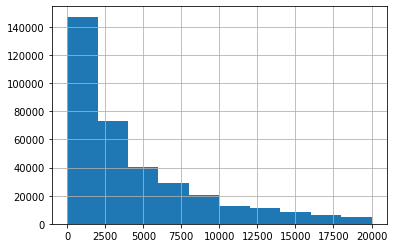

'-------------------'

'RegistrationYear'

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

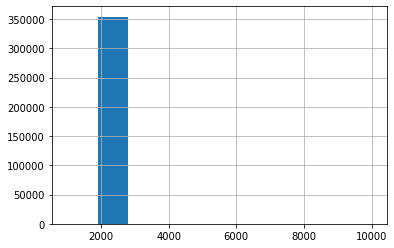

'-------------------'

'Power'

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

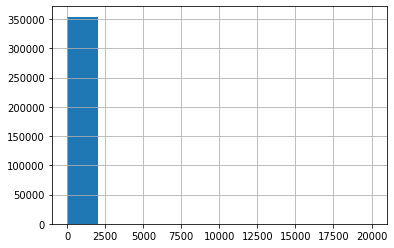

'-------------------'

'Kilometer'

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

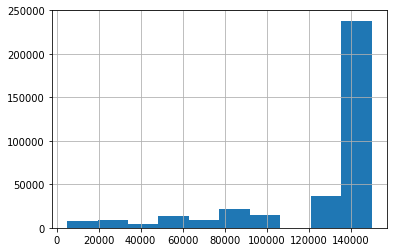

'-------------------'

'RegistrationMonth'

count    354369.000000
mean          5.714645
std           3.726421
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

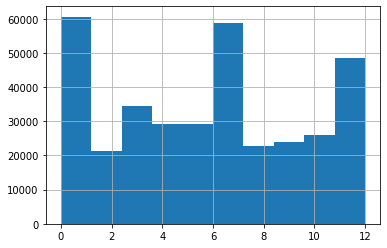

'-------------------'

'NumberOfPictures'

count    354369.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

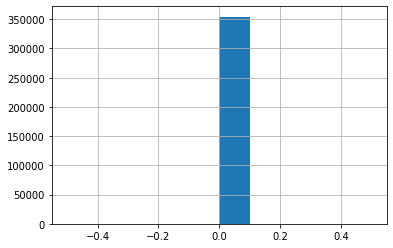

'-------------------'

'PostalCode'

count    354369.000000
mean      50508.689087
std       25783.096248
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: PostalCode, dtype: float64

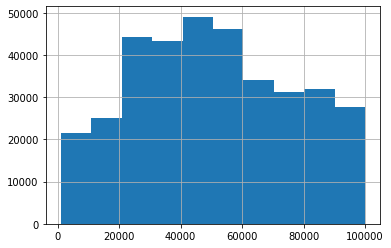

'-------------------'

In [7]:
num_columns = []
for column in df.columns:
    if df[column].dtypes == 'int':
        num_columns.append(column)

for column in num_columns:
    display(column)
    display(df[column].describe())
    df[column].hist()
    plt.show()
    display('-------------------')

Видим странные значения цене (есть нулевые значения), в годе регистрации (1000 и 9999), в мощности (0 и 20000), в месяце регистрации (интервал от 0 до 12 включительно) и бесполезность признака количество фотографий, все значения которого равны 0. Обращаем внимание на `PostalCode`, который фактически является категориальным признаком.

**Вывод**

В нашем распоряжении датафрейм из 354369 объектов и 16 признаков. Видим:
* Пропуски в столбцах `NotRepaired` (20%), `VehicleType` (11%), `FuelType` (9%), `Gearbox` (6%), `Model` (6%).
* Странные значения в `Price` (нулевые значения), `RegistrationMonth` (13 значений от 0 до 12 вместо ожидаемых 12), `RegistrationYear` (интервал значений от 1000 до 9999) и `Power` (интервал значений от 0 до 20000).
* В признаках, содержащих информацию о датах `DateCrawled`, `DateCreated` и `LastSeen` нужно будет изменить тип на datetime, 
* Также дополнительно изучим признаки с типом *object*: `VehicleType`,`Gearbox`, `Model`, `FuelType`, `Brand`, `NotRepaired` и `PostalCode`, который фактически является категориальным.
* Столбцы подлежащие удалению `DateCrawled` (содержит информацию о времени выгрузки данных, а не об объектах) и `NumberOfPictures` (для всех объектов содержит одно и то же значение 0).

### Предобработка

#### Обработка пропусков

In [8]:
na_columns = []
for column in df.columns:
    if df[column].isna().mean() > 0:
        na_columns.append(column)

for column in na_columns:
    display(column)
    display(df[column].value_counts(dropna=False, normalize=True))
    display('--------------')

'VehicleType'

sedan          0.258084
small          0.225276
wagon          0.183893
NaN            0.105794
bus            0.081201
convertible    0.057011
coupe          0.045611
suv            0.033852
other          0.009278
Name: VehicleType, dtype: float64

'--------------'

'Gearbox'

manual    0.756982
auto      0.187051
NaN       0.055967
Name: Gearbox, dtype: float64

'--------------'

'Model'

golf                  0.082490
other                 0.068914
3er                   0.055764
NaN                   0.055606
polo                  0.036871
                        ...   
i3                    0.000023
serie_3               0.000011
rangerover            0.000011
serie_1               0.000006
range_rover_evoque    0.000006
Name: Model, Length: 251, dtype: float64

'--------------'

'FuelType'

petrol      0.610527
gasoline    0.278580
NaN         0.092827
lpg         0.014984
cng         0.001594
hybrid      0.000658
other       0.000576
electric    0.000254
Name: FuelType, dtype: float64

'--------------'

'NotRepaired'

no     0.697468
NaN    0.200791
yes    0.101741
Name: NotRepaired, dtype: float64

'--------------'

Видим, что в `VehicleType`, `Gearbox` и `NotRepaired` можем заполнить пропуски значениями *no_info*. Сложнее ситуация в `Model` и `FuelType`. 

Среди объектов встречается 251 уникальная модель автомобиля, при этом второе по популярности значение - *other*. Заполним пропуски значением *no_info*, нужно будет посмотреть на значения еще раз в связке с маркой автомобиля.

В типе топлива видим серьезный перекос: 88% приходятся на значения *petrol* и *gasoline*, которые, вообще говоря, являются бензином и есть желание их объединить в одну категорию. Но объединять категории не будем, т.к. иначе получим гиперкатегорию + возможно наименование топлива как-то связано с ценой: например, зависит от года выпуска автомобиля или региона, в котором он эксплуатировался. Или, как вариант, мы видим, что среди значений нет дизельного топлива, что очень странно. Возможно, одно из значений соответсвует именно дизелю.  
Замечаем, что *lpg* и *cng* - это сжиженный газ, то есть близкие категории, которые хочется объединить в одну. А также обращаем внимание на то, что доля электрических и гибридных автомобилей очень мала, но мы ожидаем, что их цена сильно отличается от цены обычных автомобилей, поэтому оставим эти категории.  
Посмотрим на медианные цены по категориям типа топлива.

In [9]:
display(df.groupby(by='FuelType')['Price'].median().sort_values(ascending=False))
display('NaN ' + str(df[df['FuelType'].isna()]['Price'].median()))
display('df median ' + str(df['Price'].median()))

FuelType
hybrid      9990.0
electric    5799.5
gasoline    5200.0
cng         3650.0
lpg         2983.5
petrol      2000.0
other        974.5
Name: Price, dtype: float64

'NaN 1100.0'

'df median 2700.0'

Видим, что первое место по цене с огромным отрывом занимают гибридные автомобили, медианные цены на автомобили с типами топлива *petrol* и *gasoline* отличаются в разы.  
**Итого:** заполняем все пропуски значением *no_info*, никакие категории не объединяем.

In [10]:
df = df.fillna('no_info')
df.isna().mean()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

#### Приведение типов

In [11]:
for column in date_columns:
    df[column] = pd.to_datetime(df[column])
df[date_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 3 columns):
DateCrawled    354369 non-null datetime64[ns]
DateCreated    354369 non-null datetime64[ns]
LastSeen       354369 non-null datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 8.1 MB


In [12]:
df[object_columns].describe()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,354369,354369,354369,354369,354369,354369
unique,9,3,251,8,40,3
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268251,29232,216352,77013,247161


Видим, что это все категориальные переменные. При этом смущает большое количество категорий в марке и модели автобиля. Посмотрим на них внимательней.

In [13]:
df['Brand'].value_counts(normalize=True)

volkswagen        0.217324
opel              0.112682
bmw               0.104168
mercedes_benz     0.090431
audi              0.083122
ford              0.071053
renault           0.050589
peugeot           0.031035
fiat              0.027212
seat              0.019491
mazda             0.015845
skoda             0.015521
smart             0.014804
citroen           0.014527
nissan            0.013943
toyota            0.012998
hyundai           0.010122
sonstige_autos    0.009521
volvo             0.009058
mini              0.009036
mitsubishi        0.008528
honda             0.007949
kia               0.006956
suzuki            0.006555
alfa_romeo        0.006530
chevrolet         0.004950
chrysler          0.004061
dacia             0.002540
daihatsu          0.002274
subaru            0.002150
porsche           0.002139
jeep              0.001910
trabant           0.001662
land_rover        0.001538
daewoo            0.001529
saab              0.001484
jaguar            0.001425
r

In [14]:
df.groupby('Brand')['Price'].mean().sort_values(ascending=False)

Brand
porsche           10994.670185
mini               8992.646159
land_rover         8429.365138
jeep               7065.096012
jaguar             6685.538614
audi               6239.976507
bmw                6162.214661
mercedes_benz      5910.507614
skoda              5909.606727
dacia              5839.654444
chevrolet          5639.312429
hyundai            5108.007248
sonstige_autos     5026.058684
kia                4981.772414
toyota             4771.252063
volkswagen         4381.277070
volvo              4266.457632
nissan             4084.704311
seat               3997.564355
suzuki             3875.147654
chrysler           3710.838777
subaru             3698.850394
alfa_romeo         3697.622731
saab               3668.102662
honda              3649.479233
mazda              3620.883526
smart              3487.832634
citroen            3467.194639
ford               3175.719846
peugeot            3111.897709
lada               3037.444444
mitsubishi         2932.187624
op

40 значений для категориальной переменной - это много, но марка автомобиля сильно влияет на цену, поэтому не будем укрупнять категории.

Посмотрим на марки автомобилей. 

In [15]:
df['Model'].str.lower().nunique()

251

In [16]:
df['Model'].nunique()

251

Видим, что дублей, скрытых регистром нет. Посмотрим на отсортированные названия моделей, может быть есть опечатки.

In [17]:
sorted(list(df['Model'].unique()))

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

Массовых проблем, увы, не видим. Видим написание 'range_rover' и 'rangerover', а также потенциальные повторы вида 'c_klasse'/'c_reihe', 'm_klasse'/'m_reihe', 's_klasse'/'s_type', 'x_reihe'/'x_type'. Первое 

In [18]:
df.loc[df['Model'] == 'rangerover', 'Model'] = 'range_rover'

In [19]:
df.query("Model in ['c_reihe', 'c_klasse']").groupby(['Model', 'Brand'])['Brand'].count()

Model     Brand        
c_klasse  mercedes_benz    8312
c_reihe   volvo             193
Name: Brand, dtype: int64

In [20]:
df.query("Model in ['m_klasse', 'm_reihe']").groupby(['Model', 'Brand'])['Brand'].count()

Model     Brand        
m_klasse  mercedes_benz    953
m_reihe   bmw              132
Name: Brand, dtype: int64

In [21]:
df.query("Model in ['s_klasse', 's_type']").groupby(['Model', 'Brand'])['Brand'].count()

Model     Brand        
s_klasse  mercedes_benz    892
s_type    jaguar           128
Name: Brand, dtype: int64

In [22]:
df.query("Model in ['x_reihe', 'x_type']").groupby(['Model', 'Brand'])['Brand'].count()

Model    Brand 
x_reihe  bmw       1589
x_type   jaguar     173
Name: Brand, dtype: int64

Видим, что пары значений специфичны для производителей автомобилей. Оставим всё без изменений.

In [23]:
for brand_name in df['Brand'].unique():

    brand_name_df = df.query('Brand == @brand_name')
    number_of_models = brand_name_df['Model'].nunique()
    display(f'Марка {brand_name}, количество моделей {number_of_models}')
    display(brand_name_df['Model'].unique())
    display(brand_name_df.groupby('Model')['Price'].agg(['mean', 'count']).sort_values(by='mean', ascending=False).head(number_of_models))
    display('--------------')

'Марка volkswagen, количество моделей 23'

array(['golf', 'other', 'passat', 'polo', 'scirocco', 'transporter',
       'jetta', 'no_info', 'eos', 'touran', 'lupo', 'caddy', 'tiguan',
       'sharan', 'up', 'fox', 'beetle', 'touareg', 'kaefer', 'phaeton',
       'cc', 'bora', 'amarok'], dtype=object)

,mean,count
Model,,
tiguan,14138.638973,662
cc,14118.773723,137
amarok,12153.687500,16
eos,10996.970930,516
scirocco,10546.975207,605
touareg,10420.767918,586
phaeton,9470.794393,214
up,7966.574713,348
touran,7126.566282,3470


'--------------'

'Марка audi, количество моделей 17'

array(['no_info', 'a8', 'a4', 'a1', 'tt', 'a6', '80', '100', 'a3', 'a2',
       'a5', 'other', '90', 'q7', 'q3', '200', 'q5'], dtype=object)

,mean,count
Model,,
q5,15843.989691,97
a5,15531.853211,545
q7,15255.019512,205
a1,13839.910924,595
q3,13444.000000,15
tt,9598.250929,1076
other,8350.000000,1033
a8,7796.776938,529
a6,6375.442700,5541


'--------------'

'Марка jeep, количество моделей 5'

array(['grand', 'wrangler', 'cherokee', 'other', 'no_info'], dtype=object)

,mean,count
Model,,
other,10702.094203,138
wrangler,9317.757282,103
grand,6116.937759,241
cherokee,4508.786982,169
no_info,4241.730769,26


'--------------'

'Марка skoda, количество моделей 8'

array(['fabia', 'yeti', 'octavia', 'roomster', 'other', 'no_info',
       'superb', 'citigo'], dtype=object)

,mean,count
Model,,
yeti,13487.068966,174
superb,10233.614754,366
citigo,7470.021978,91
roomster,6807.985507,276
octavia,6581.181689,2108
fabia,4183.921635,2080
other,3193.606061,264
no_info,3070.978723,141


'--------------'

'Марка bmw, количество моделей 11'

array(['3er', '5er', '1er', '7er', 'z_reihe', 'no_info', '6er', 'other',
       'x_reihe', 'm_reihe', 'i3'], dtype=object)

,mean,count
Model,,
6er,12240.621795,156
m_reihe,11697.439394,132
x_reihe,11684.142857,1589
z_reihe,9944.803347,717
1er,9928.136312,3514
7er,6430.882006,1017
5er,6375.408236,7868
other,5934.640553,217
3er,4984.401042,19761


'--------------'

'Марка peugeot, количество моделей 7'

array(['2_reihe', '3_reihe', 'no_info', 'other', '4_reihe', '1_reihe',
       '5_reihe'], dtype=object)

,mean,count
Model,,
5_reihe,11812.185841,113
other,3878.310404,1163
4_reihe,3425.871473,638
3_reihe,3379.352833,2171
2_reihe,3154.388081,4816
no_info,1861.634119,891
1_reihe,1664.070481,1206


'--------------'

'Марка ford, количество моделей 15'

array(['c_max', 'ka', 'fiesta', 'escort', 'focus', 'mustang', 'mondeo',
       's_max', 'galaxy', 'other', 'transit', 'no_info', 'fusion', 'kuga',
       'b_max'], dtype=object)

,mean,count
Model,,
kuga,13936.812500,320
b_max,12325.653846,26
mustang,11749.412429,177
s_max,10190.768519,432
c_max,6158.416910,686
transit,4369.977454,754
other,3761.746402,1459
galaxy,3635.051038,1156
focus,3407.423391,5874


'--------------'

'Марка mazda, количество моделей 9'

array(['3_reihe', 'other', '6_reihe', '5_reihe', 'rx_reihe', '1_reihe',
       'mx_reihe', 'no_info', 'cx_reihe'], dtype=object)

,mean,count
Model,,
cx_reihe,13164.060606,66
5_reihe,6662.881459,329
mx_reihe,5069.703156,1014
rx_reihe,5009.669014,142
6_reihe,3412.023474,1278
3_reihe,2949.850983,1322
other,2499.960474,1012
no_info,1567.187500,352
1_reihe,764.140000,100


'--------------'

'Марка nissan, количество моделей 10'

array(['navara', 'micra', 'almera', 'other', 'primera', 'juke', 'qashqai',
       'no_info', 'x_trail', 'note'], dtype=object)

,mean,count
Model,,
qashqai,12622.350282,531
juke,11498.166667,102
navara,9380.571429,98
x_trail,6382.850962,208
other,5545.816239,702
note,5131.946154,130
no_info,2787.096618,207
micra,1806.166098,1758
almera,1458.868151,584


'--------------'

'Марка renault, количество моделей 11'

array(['twingo', 'clio', 'kangoo', 'scenic', 'no_info', 'megane', 'r19',
       'espace', 'modus', 'other', 'laguna'], dtype=object)

,mean,count
Model,,
other,5455.997906,955
modus,3180.414330,321
megane,2991.864261,2910
scenic,2492.448824,1446
kangoo,2457.050104,958
clio,2151.947265,3546
laguna,2130.960411,1364
espace,2069.105519,616
no_info,1398.266667,735


'--------------'

'Марка mercedes_benz, количество моделей 19'

array(['a_klasse', 'other', 'e_klasse', 'b_klasse', 'c_klasse', 'vito',
       'sprinter', 'slk', 'viano', 's_klasse', 'sl', 'clk', 'no_info',
       'v_klasse', 'm_klasse', 'cl', 'g_klasse', 'glk', 'gl'],
      dtype=object)

,mean,count
Model,,
gl,16965.076923,13
glk,16057.515625,64
sl,12857.076923,403
viano,11719.839080,261
g_klasse,10274.845361,97
b_klasse,9484.790378,873
m_klasse,9311.791186,953
slk,8703.295993,1223
cl,8200.486957,230


'--------------'

'Марка opel, количество моделей 17'

array(['meriva', 'kadett', 'corsa', 'signum', 'astra', 'other',
       'insignia', 'combo', 'omega', 'zafira', 'vectra', 'no_info',
       'agila', 'tigra', 'calibra', 'antara', 'vivaro'], dtype=object)

,mean,count
Model,,
insignia,11499.280811,641
antara,8762.555556,108
vivaro,6557.647975,321
other,6183.781498,1135
meriva,4611.884981,1052
signum,3821.977688,493
zafira,3697.030552,3044
astra,3017.163937,10809
tigra,2632.861850,789


'--------------'

'Марка seat, количество моделей 11'

array(['arosa', 'other', 'ibiza', 'cordoba', 'mii', 'leon', 'exeo',
       'alhambra', 'no_info', 'toledo', 'altea'], dtype=object)

,mean,count
Model,,
exeo,11345.600000,100
mii,7549.913580,81
leon,7112.877301,1304
altea,6395.889785,372
alhambra,5029.109244,357
ibiza,3605.079941,2702
no_info,2236.991489,235
toledo,2066.282799,343
arosa,1089.030033,899


'--------------'

'Марка citroen, количество моделей 8'

array(['c4', 'berlingo', 'c1', 'other', 'c3', 'c5', 'no_info', 'c2'],
      dtype=object)

,mean,count
Model,,
c4,5918.560811,444
c5,4388.177551,490
c3,3886.278656,506
c1,3857.381074,391
berlingo,3208.405340,824
other,2962.956193,1849
c2,2655.141772,395
no_info,1708.289157,249


'--------------'

'Марка honda, количество моделей 6'

array(['civic', 'other', 'jazz', 'accord', 'cr_reihe', 'no_info'],
      dtype=object)

,mean,count
Model,,
cr_reihe,5831.014493,345
accord,4565.273504,351
jazz,4546.947020,302
other,3613.577287,317
civic,2797.525612,1347
no_info,2448.535484,155


'--------------'

'Марка fiat, количество моделей 11'

array(['punto', 'no_info', 'other', 'panda', 'seicento', '500', 'stilo',
       'ducato', 'bravo', 'croma', 'doblo'], dtype=object)

,mean,count
Model,,
500,7702.017391,920
croma,3980.266667,45
ducato,3850.754023,435
doblo,3578.129231,325
panda,3102.130178,676
other,2851.624371,1789
bravo,2661.419940,331
punto,1637.711383,3347
no_info,1618.870518,502


'--------------'

'Марка mini, количество моделей 5'

array(['one', 'cooper', 'other', 'clubman', 'no_info'], dtype=object)

,mean,count
Model,,
clubman,10623.621891,201
cooper,9783.263590,1950
other,7684.728261,92
one,7217.986622,897
no_info,6455.032258,62


'--------------'

'Марка smart, количество моделей 5'

array(['fortwo', 'no_info', 'other', 'roadster', 'forfour'], dtype=object)

,mean,count
Model,,
roadster,4930.149171,181
fortwo,3596.747060,4337
forfour,2886.746114,386
other,2266.162162,74
no_info,1954.257463,268


'--------------'

'Марка hyundai, количество моделей 6'

array(['other', 'getz', 'i_reihe', 'santa', 'no_info', 'tucson'],
      dtype=object)

,mean,count
Model,,
i_reihe,8259.898042,1226
tucson,6580.640693,231
santa,5888.725240,313
no_info,2905.605263,228
other,2868.359040,1167
getz,1949.372038,422


'--------------'

'Марка sonstige_autos, количество моделей 1'

array(['no_info'], dtype=object)

,mean,count
Model,,
no_info,5026.058684,3374


'--------------'

'Марка alfa_romeo, количество моделей 7'

array(['156', '147', 'no_info', 'spider', '159', 'other', '145'],
      dtype=object)

,mean,count
Model,,
159,7061.297170,212
spider,6938.221649,194
other,6064.669866,521
147,2270.666084,572
no_info,1912.175182,137
156,1514.076312,629
145,825.571429,49


'--------------'

'Марка subaru, количество моделей 6'

array(['forester', 'impreza', 'justy', 'legacy', 'other', 'no_info'],
      dtype=object)

,mean,count
Model,,
other,5403.531250,64
forester,5008.561538,130
impreza,4895.217778,225
legacy,2672.825000,160
no_info,2068.318182,44
justy,1449.661871,139


'--------------'

'Марка volvo, количество моделей 10'

array(['xc_reihe', 'v40', 'no_info', 'v50', 'other', 'c_reihe', 'v70',
       's60', '850', 'v60'], dtype=object)

,mean,count
Model,,
v60,14827.380952,42
xc_reihe,11617.483146,267
c_reihe,7990.031088,193
s60,6085.739726,146
v50,5981.356863,255
v70,3894.327014,633
other,3249.283737,578
no_info,1916.394495,109
v40,1493.411613,775


'--------------'

'Марка mitsubishi, количество моделей 8'

array(['other', 'colt', 'no_info', 'carisma', 'galant', 'lancer',
       'pajero', 'outlander'], dtype=object)

,mean,count
Model,,
outlander,9118.105691,123
pajero,5737.086538,208
lancer,3701.049550,222
other,3530.001300,769
colt,2360.266974,869
no_info,1683.131250,160
galant,1140.821012,257
carisma,957.637681,414


'--------------'

'Марка kia, количество моделей 8'

array(['sportage', 'sorento', 'ceed', 'rio', 'other', 'picanto',
       'no_info', 'carnival'], dtype=object)

,mean,count
Model,,
sportage,10502.693548,248
ceed,7852.222222,252
sorento,6905.281525,341
rio,4115.294430,377
picanto,3462.533149,362
other,3183.729459,499
no_info,2695.867257,113
carnival,2357.959707,273


'--------------'

'Марка suzuki, количество моделей 5'

array(['other', 'grand', 'swift', 'no_info', 'jimny'], dtype=object)

,mean,count
Model,,
grand,7824.100000,210
jimny,6775.495283,212
swift,3958.849645,705
other,2631.402266,1059
no_info,2517.211679,137


'--------------'

'Марка lancia, количество моделей 8'

array(['other', 'ypsilon', 'lybra', 'no_info', 'musa', 'delta',
       'elefantino', 'kappa'], dtype=object)

,mean,count
Model,,
delta,5023.914286,35
other,4505.161616,99
musa,3109.520000,25
kappa,2089.933333,15
no_info,1622.956522,23
ypsilon,1396.368421,209
lybra,768.203704,54
elefantino,522.636364,11


'--------------'

'Марка toyota, количество моделей 9'

array(['other', 'avensis', 'no_info', 'corolla', 'verso', 'rav', 'yaris',
       'aygo', 'auris'], dtype=object)

,mean,count
Model,,
auris,9059.824786,234
rav,7049.725714,350
verso,6957.980583,309
avensis,5624.769912,565
other,4602.995261,844
aygo,4219.313953,430
yaris,3861.257502,1033
no_info,3308.949045,157
corolla,2709.877193,684


'--------------'

'Марка chevrolet, количество моделей 6'

array(['other', 'matiz', 'no_info', 'spark', 'captiva', 'aveo'],
      dtype=object)

,mean,count
Model,,
captiva,10178.095238,168
other,6226.007368,950
spark,4904.976000,125
aveo,4653.393162,117
no_info,4650.118182,110
matiz,2104.383803,284


'--------------'

'Марка dacia, количество моделей 6'

array(['logan', 'duster', 'sandero', 'lodgy', 'no_info', 'other'],
      dtype=object)

,mean,count
Model,,
lodgy,10362.771429,35
duster,10028.348039,204
other,5763.454545,22
no_info,5184.954545,22
sandero,4875.477966,295
logan,3627.571429,322


'--------------'

'Марка daihatsu, количество моделей 8'

array(['cuore', 'sirion', 'other', 'charade', 'move', 'no_info', 'terios',
       'materia'], dtype=object)

,mean,count
Model,,
materia,4882.055556,18
terios,4790.171429,35
other,2420.877193,114
sirion,2251.532374,139
no_info,1466.871795,39
charade,1236.518519,27
cuore,1052.500000,374
move,606.366667,60


'--------------'

'Марка trabant, количество моделей 3'

array(['no_info', 'other', '601'], dtype=object)

,mean,count
Model,,
other,2327.253333,75
601,1617.133652,419
no_info,1058.778947,95


'--------------'

'Марка saab, количество моделей 4'

array(['no_info', 'other', '900', '9000'], dtype=object)

,mean,count
Model,,
other,4069.410468,363
900,3103.577586,116
9000,2072.354839,31
no_info,1748.000000,16


'--------------'

'Марка chrysler, количество моделей 7'

array(['other', 'ptcruiser', 'crossfire', '300c', 'grand', 'voyager',
       'no_info'], dtype=object)

,mean,count
Model,,
crossfire,10603.062500,64
300c,9862.806897,145
grand,4216.736364,110
no_info,3148.606742,89
other,2969.131234,381
ptcruiser,2408.961039,308
voyager,1795.111111,342


'--------------'

'Марка jaguar, количество моделей 4'

array(['other', 'x_type', 's_type', 'no_info'], dtype=object)

,mean,count
Model,,
other,9980.210526,190
x_type,4790.976879,173
s_type,4609.523438,128
no_info,4364.214286,14


'--------------'

'Марка daewoo, количество моделей 6'

array(['lanos', 'kalos', 'matiz', 'other', 'nubira', 'no_info'],
      dtype=object)

,mean,count
Model,,
kalos,1491.168421,95
other,1117.560440,91
matiz,997.452830,159
nubira,935.758065,62
no_info,828.000000,46
lanos,602.191011,89


'--------------'

'Марка porsche, количество моделей 5'

array(['other', 'boxster', 'cayenne', '911', 'no_info'], dtype=object)

,mean,count
Model,,
cayenne,13014.547414,232
boxster,12970.932127,221
911,10326.738095,84
other,7806.960894,179
no_info,4359.928571,42


'--------------'

'Марка rover, количество моделей 6'

array(['other', 'discovery', 'no_info', 'range_rover', 'freelander',
       'defender'], dtype=object)

,mean,count
Model,,
range_rover,5937.500000,4
discovery,2950.000000,2
freelander,1583.333333,3
other,1341.271574,394
no_info,931.951220,82
defender,550.000000,1


'--------------'

'Марка land_rover, количество моделей 11'

array(['discovery', 'freelander', 'defender', 'no_info', 'range_rover',
       'serie_2', 'range_rover_sport', 'other', 'range_rover_evoque',
       'serie_3', 'serie_1'], dtype=object)

,mean,count
Model,,
range_rover_sport,15332.796296,54
range_rover_evoque,12500.000000,2
defender,11487.946667,75
serie_3,9812.500000,4
discovery,9440.584416,77
serie_2,9315.375000,8
other,7498.888889,18
range_rover,7401.935065,77
freelander,5907.493023,215


'--------------'

'Марка lada, количество моделей 5'

array(['other', 'samara', 'niva', 'no_info', 'kalina'], dtype=object)

,mean,count
Model,,
niva,3685.410853,129
other,2526.694915,59
no_info,2192.600000,15
kalina,1911.000000,9
samara,680.307692,13


'--------------'

Видим, что от модели цена тоже сильно зависит, поэтому оставим как есть и посмотрим, смогут ли такое количество значений переварить модели. Если нет, то придется отказаться от этого признака.

Приведем тип признаков к типу *category*.

In [24]:
df[object_columns] = df[object_columns].astype('category')
df[object_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 6 columns):
VehicleType    354369 non-null category
Gearbox        354369 non-null category
Model          354369 non-null category
FuelType       354369 non-null category
Brand          354369 non-null category
NotRepaired    354369 non-null category
dtypes: category(6)
memory usage: 2.4 MB


Посмотрим еще на `PostalCode`.

In [25]:
df['PostalCode'].nunique()

8143

Видим 8143 уникальных значений. Удалим его, нет сомнений, что модели не "переварят" такой категориальный признак, а использовать его в качестве количественного было бы странно.

In [26]:
df = df.drop(columns=['PostalCode'])

#### Дубликаты

In [27]:
df[df.drop(columns=['DateCrawled']).duplicated(keep=False)].sort_values(by=['Price', 'Model'])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,LastSeen
51498,2016-03-15 10:56:46,0,wagon,2006,manual,122,other,150000,1,no_info,chevrolet,no,2016-03-15,0,2016-03-18 03:18:11
256274,2016-03-15 10:56:47,0,wagon,2006,manual,122,other,150000,1,no_info,chevrolet,no,2016-03-15,0,2016-03-18 03:18:11
317037,2016-03-28 22:38:12,350,wagon,1997,manual,0,other,150000,0,gasoline,citroen,no_info,2016-03-28,0,2016-04-07 07:16:49
321310,2016-03-28 22:38:13,350,wagon,1997,manual,0,other,150000,0,gasoline,citroen,no_info,2016-03-28,0,2016-04-07 07:16:49
186618,2016-04-03 22:56:46,500,sedan,1997,manual,88,3_reihe,100000,11,petrol,mazda,no,2016-04-03,0,2016-04-06 00:16:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77480,2016-03-16 21:58:18,15700,suv,2011,manual,189,other,90000,6,petrol,mini,no,2016-03-16,0,2016-03-27 14:16:03
47091,2016-03-31 02:56:59,16499,sedan,2010,manual,204,5er,150000,7,gasoline,bmw,no,2016-03-31,0,2016-04-06 00:17:14
302493,2016-03-31 02:57:00,16499,sedan,2010,manual,204,5er,150000,7,gasoline,bmw,no,2016-03-31,0,2016-04-06 00:17:14
267786,2016-03-26 23:06:25,17999,wagon,2011,auto,143,a4,90000,8,gasoline,audi,no,2016-03-26,0,2016-04-07 00:17:35


Видим грубые дубли, удалим их.

In [28]:
df = df.drop_duplicates(subset=['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'LastSeen'])
df.drop(columns=['DateCrawled']).duplicated(keep=False).sum()

0

#### Выбросы

Удалим столбец с количеством фотографий. Необходимо уточнить, возможно, это ошибка сбора данных. Маловероятно, что во всех 350 тысяч объявлений отсутствуют фотографии.

Также удалим столбец c датой скачивания анкеты из базы.


In [29]:
df = df.drop(columns=['NumberOfPictures', 'DateCrawled'])

##### Год регистрации

Посмотрим на необычные значения года регистрации. В качестве необычных возьмем те, в которых год регистрации больше года создания объявления, то есть машина зарегистрирована позже, чем создано объявление. Также посмотрим на слишком старые автомобили, у которых год регистрации меньше, чем 1950.

In [30]:
df[df['RegistrationYear'] > df['DateCreated'].dt.year]['RegistrationYear'].unique()

array([2018, 2017, 5000, 9999, 3200, 8888, 2200, 4100, 3000, 2066, 2019,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 4000, 8500, 3700, 3800,
       4800, 7000, 6500, 2290, 2500, 9450, 2800, 5555, 5600, 2222, 9996,
       8455, 4500, 7800, 9229, 7100, 8200, 7500, 3500])

Хм, видим несколько разумных значений: 2017, 2018, 2019. Остальные заведомо неправильные. При это непонятно, как могло быть в 2016 году создано объявление о машине, которая будет зарегистрирована только в 2017 году. Поэтому эти значения тоже удалим, как сомнительные. 

In [31]:
to_be_deleted = sum(df['RegistrationYear'] > df['DateCreated'].dt.year) / len(df)
display(f'Доля значений к удалению {round(to_be_deleted, 2)}')

'Доля значений к удалению 0.04'

In [32]:
df = df.drop(df[df['RegistrationYear'] > df['DateCreated'].dt.year].index)

In [33]:
df[df['RegistrationYear'] < 1980]['RegistrationYear'].value_counts()

1970    333
1978    285
1979    283
1972    213
1960    188
       ... 
1001      1
1915      1
1255      1
1253      1
1931      1
Name: RegistrationYear, Length: 73, dtype: int64

Видим, что доля автомобилей старше 1980 года мала. Удалим их из датасета.

In [34]:
to_be_deleted = len(df[df['RegistrationYear'] < 1980]) / len(df)
display(f'Доля значений к удалению {round(to_be_deleted, 3)}')

'Доля значений к удалению 0.01'

In [35]:
df = df.drop(df[df['RegistrationYear'] < 1980].index)

##### Мощность двигателя

Посмотрим на мощность двигателя. Ранее мы видели нереалистично большие значения.

In [36]:
df['Power'].describe()

count    336286.000000
mean        111.360598
std         185.535316
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Видим, что IQR = 73. В качестве критерия отсева выбросов возьмем Q3 + 3IQR = 143 + 3 * 73 = 362

In [37]:
to_be_deleted = len(df[df['Power'] > 362]) / len(df)
display(f'Доля значений к удалению {round(to_be_deleted, 3)}')

'Доля значений к удалению 0.003'

In [38]:
df = df.drop(df[df['Power'] > 362].index)

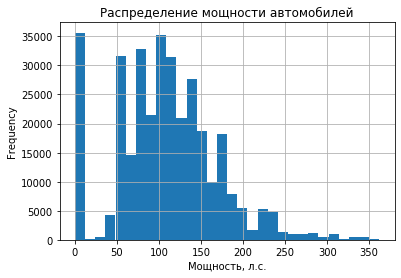

In [39]:
df['Power'].plot(kind='hist', title='Распределение мощности автомобилей', grid=True, bins=30)
plt.xlabel('Мощность, л.с.')
plt.show()

Обращает на себя внимание группа значений около нуля. Посмотрим на них

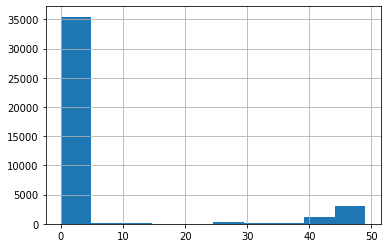

In [40]:
df[df['Power'] < 50]['Power'].hist()

In [41]:
df[df['Power'] < 10]['Power'].value_counts()

0    35366
5      102
4       30
1       27
7       11
6       11
2       10
3        8
8        6
9        4
Name: Power, dtype: int64

Удалим нулевые значения.

In [42]:
to_be_deleted = len(df[df['Power'] < 1]) / len(df)
display(f'Доля значений к удалению {round(to_be_deleted, 3)}')

'Доля значений к удалению 0.105'

In [43]:
df = df.drop(df[df['Power'] < 1].index)

##### Месяц регистрации

3     30540
6     27827
4     25969
5     25877
7     23851
10    23187
12    21492
11    21249
9     21154
1     20307
8     19976
0     19499
2     19010
Name: RegistrationMonth, dtype: int64

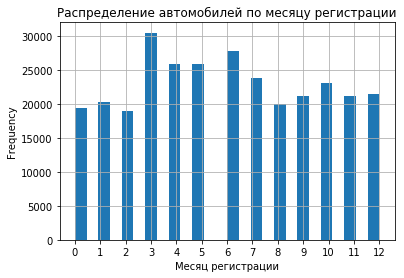

In [44]:
display(df['RegistrationMonth'].value_counts())
df['RegistrationMonth'].plot(kind='hist', bins=26, xticks=[i for i in range(13)], grid=True)
plt.title('Распределение автомобилей по месяцу регистрации')
plt.xlabel('Месяц регистрации')
plt.show()

Надо уточнить, как собирались данные. Вижу три возможных варианта:
1. Значение **0** было проставлено автоматически в тех случаях, когда информация о месяце регистрации отсутствовала.
2. Значение **0** было проставлено некоторыми пользователями вместо значения **12**.
3. Данные собраны из двух источников, в которых месяца кодировались по-разному: интервалами от 0 до 11 и от 1 до 12. 
Не имея дополнительной информации, принимаем решение ничего не делать с этим признаком. При этом ожидаем, что месяц регистрации скорее всего не сильно влиет на цену автомобиля. 

Изменим тип данных на *category* и двигаемся дальше.

In [45]:
df['RegistrationMonth'] = df['RegistrationMonth'].astype('category')

##### Цена

Посмотрим на распределение цен. При знакомстве нас смутило наличие нулевых значений.

In [46]:
df.Price.describe()

count    299938.000000
mean       4710.723306
std        4582.467430
min           0.000000
25%        1250.000000
50%        2999.000000
75%        6900.000000
max       20000.000000
Name: Price, dtype: float64

'Уникальные значений'

array([ 0,  1,  2,  3,  5,  9, 10, 11, 12, 13, 15, 16, 17, 20, 24, 25, 26,
       29, 30, 35, 38, 39, 40, 45, 47, 49, 50, 55, 60, 65, 66, 69, 70, 75,
       77, 79, 80, 85, 89, 90, 95, 98, 99])

'Наиболее частые значения в интервале от 0 до 100'

0     6297
1      640
50     151
80      70
99      58
70      30
75      28
10      24
90      22
60      22
Name: Price, dtype: int64

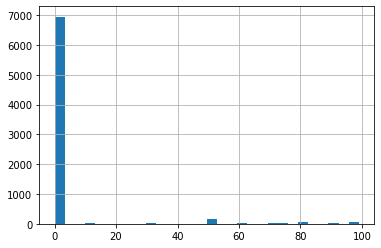

In [47]:
display('Уникальные значений')
display(np.sort(df[df['Price'] < 100]['Price'].unique()))
display('Наиболее частые значения в интервале от 0 до 100')
display(df[df['Price'] < 100]['Price'].value_counts().head(10))
df[df['Price'] < 100]['Price'].hist(bins=30)

Видим большую группу объектов с нулевой ценой, что неправдоподобно. Удалим эти объекты из рассмотрения.

In [48]:
to_be_deleted = len(df[df['Price'] == 0]) / len(df)
display(f'Доля значений к удалению {round(to_be_deleted, 2)}')

'Доля значений к удалению 0.02'

In [49]:
df = df.drop(df[df['Price'] == 0].index)

#### Вывод

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293641 entries, 1 to 354368
Data columns (total 13 columns):
Price                293641 non-null int64
VehicleType          293641 non-null category
RegistrationYear     293641 non-null int64
Gearbox              293641 non-null category
Power                293641 non-null int64
Model                293641 non-null category
Kilometer            293641 non-null int64
RegistrationMonth    293641 non-null category
FuelType             293641 non-null category
Brand                293641 non-null category
NotRepaired          293641 non-null category
DateCreated          293641 non-null datetime64[ns]
LastSeen             293641 non-null datetime64[ns]
dtypes: category(7), datetime64[ns](2), int64(4)
memory usage: 17.9 MB


* Заполнены пропуски в `VehicleType`, `Gearbox`, `NotRepaired`, `Model` и `FuelType` значением *no_info*.
* Приведены типы данных в признаках, содержащих информацию о дате, к типу *datetime* и в категориальных - к типу *category*.
* Изучены категориальные признаки. У признаков `Brand` и `Model` увидели большое количество уникальных значений (40 и 251), что может быть проблемой при обучении моделей. Обнаружили один скрытый дубликат в `Model`, пофиксили, но ситуацию это не меняет.
* Удалены признаки `PostalCode`, `NumberOfPictures` и`DateCrawled` как неинформативные.
* Удалены грубые дубликаты объектов.
* Удалены выбросы в количественных значениях `RegistrationYear`, `Power` и `Price`. 
* В признаке `RegistrationMonth` обнаружена проблема: 13 уникальных значений вместо ожидаемых 12. Без понимания того, каким образом это получилось, корректировать значения не стали. Привели признак к типу `category`.

После предобработки размер датафрейма уменьшился до 293654 объектов и 13 признаков.

## Обучение моделей

### Подготовка данных

Создадим список категориальных фичей.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293641 entries, 1 to 354368
Data columns (total 13 columns):
Price                293641 non-null int64
VehicleType          293641 non-null category
RegistrationYear     293641 non-null int64
Gearbox              293641 non-null category
Power                293641 non-null int64
Model                293641 non-null category
Kilometer            293641 non-null int64
RegistrationMonth    293641 non-null category
FuelType             293641 non-null category
Brand                293641 non-null category
NotRepaired          293641 non-null category
DateCreated          293641 non-null datetime64[ns]
LastSeen             293641 non-null datetime64[ns]
dtypes: category(7), datetime64[ns](2), int64(4)
memory usage: 17.9 MB


In [52]:
cat_features = ['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 
               'RegistrationMonth']

Начнем с простых моделей: константной модели (предсказание по среднему) и модели линейной регрессии. В связи с тем, что в категориальном признаке `Model` у нас много уникальных значений, попробуем линейную регрессию как на полном наборе признаков, так и без использования признака `Model`: это должно ухудшить качество, но заметно улучшить скорость работы модели.

Будем сравнивать качество предсказания (RMSE), время обучения и скорость предсказания. Данные об этих характеристиках будем хранить в датафрейме **model_comparison**.

In [53]:
model_comparison = pd.DataFrame(columns=['rmse', 'learning_time', 'prediction_time'])

Посмотрим на корреляцию численных признаков. Приведем `DateCreated` и `LastSeen` к числовому типу, т.к. линейная регрессия и LGBM не работают с типом *timestamp*.

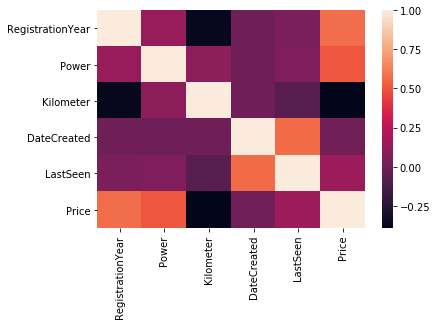

,RegistrationYear,Power,Kilometer,DateCreated,LastSeen,Price
RegistrationYear,1.000000,0.138818,-0.366400,-0.002964,0.040378,0.571382
Power,0.138818,1.000000,0.105554,0.000462,0.056253,0.510463
Kilometer,-0.366400,0.105554,1.000000,0.000696,-0.065447,-0.390763
DateCreated,-0.002964,0.000462,0.000696,1.000000,0.569459,0.011961
LastSeen,0.040378,0.056253,-0.065447,0.569459,1.000000,0.149098
Price,0.571382,0.510463,-0.390763,0.011961,0.149098,1.000000


In [54]:
df[['DateCreated', 'LastSeen']] = df[['DateCreated', 'LastSeen']].astype('int')
num_features = ['RegistrationYear', 'Power', 'Kilometer', 'DateCreated', 'LastSeen']

sns.heatmap(df[num_features + ['Price']].corr())
plt.show()
corr_matrix = df[num_features + ['Price']].corr()
display(corr_matrix)

Ожидаемо видим положительную корреляцию цены с годом регистрации, мощностью и отрицательную - с пробегом. Ожидаемо не наблюдаем сильной корреляции с датой создания анкеты и датой последней актичности пользователя.

Разобьем датафрейм на тренировочную, валидационную и тестовую выборки.

In [55]:
df_train, df_test_valid = train_test_split(df, test_size=0.4, random_state=42)
df_test, df_valid = train_test_split(df_test_valid, test_size=0.5, random_state=42)
del df_test_valid

train_features = df_train.drop(columns=['Price'])
train_target = df_train['Price']
valid_features = df_valid.drop(columns=['Price'])
valid_target = df_valid['Price']
test_features = df_test.drop(columns=['Price'])
test_target = df_test['Price']

In [56]:
scaler = StandardScaler()
scaler.fit(train_features[num_features])

train_features[num_features] = scaler.transform(train_features[num_features])
valid_features[num_features] = scaler.transform(valid_features[num_features])
test_features[num_features] = scaler.transform(test_features[num_features])

### Dummy Regression (mean)

Начнем с константной модели. Время обучения/предсказания может несколько варьироваться, поэтому будем повторим обучение/предсказание 10 раз и посмотрим, какой разброс получим.

In [57]:
%%time

learning_time = []
prediction_time = []

for _ in tqdm(range(10)):
    model_dummy = DummyRegressor(strategy='mean')

    start_time = time.time()
    model_dummy.fit(train_features, train_target)
    end_time = time.time()
    learning_time.append(end_time - start_time)

    start_time = time.time()
    predictions = model_dummy.predict(test_features)
    end_time = time.time()
    prediction_time.append(end_time - start_time)
    # без задержки второе и следующие значения выглядят заниженными
    time.sleep(1)
    
rmse_test = mean_squared_error(test_target, predictions) ** 0.5


CPU times: user 84.6 ms, sys: 8.8 ms, total: 93.4 ms
Wall time: 10.1 s


In [58]:
learning_time_mean = pd.Series(learning_time).describe()[1]
prediction_time_mean = pd.Series(prediction_time).describe()[1]
display(f'Learning time: {learning_time_mean} +- {pd.Series(learning_time).describe()[2]}')
display(f'Prediction time: {prediction_time_mean} +- {pd.Series(prediction_time).describe()[2]}')
model_comparison.loc['dummy_mean', :] = [round(rmse_test, 0), round(learning_time_mean, 5), 
                                         round(prediction_time_mean, 5)]
model_comparison

'Learning time: 0.0011115312576293946 +- 0.0001375016190145965'

'Prediction time: 0.0003188133239746094 +- 9.961312236864852e-05'

,rmse,learning_time,prediction_time
dummy_mean,4577,0.00111,0.00032


### Линейная регрессия

Доподготовим данные для лин.регрессии, закодировав категориальные признаки. Уменьшим количество повторов до 3, т.к. ожидаем, что обучение будем небыстрым.

In [59]:
train_features_OHE = pd.get_dummies(train_features, drop_first=True)
test_features_OHE = pd.get_dummies(test_features, drop_first=True)

In [60]:
%%time

learning_time = []
prediction_time = []

for _ in tqdm(range(3)):
    model_linreg = LinearRegression()

    start_time = time.time()
    model_linreg.fit(train_features_OHE, train_target)
    end_time = time.time()
    learning_time.append(end_time - start_time)

    start_time = time.time()
    predictions = model_linreg.predict(test_features_OHE)
    end_time = time.time()
    prediction_time.append(end_time - start_time)
    
rmse_test = mean_squared_error(test_target, predictions) ** 0.5


CPU times: user 45.3 s, sys: 18.1 s, total: 1min 3s
Wall time: 1min 3s


In [61]:
learning_time_mean = pd.Series(learning_time).describe()[1]
prediction_time_mean = pd.Series(prediction_time).describe()[1]
display(f'Learning time: {learning_time_mean} +- {pd.Series(learning_time).describe()[2]}')
display(f'Prediction time: {prediction_time_mean} +- {pd.Series(prediction_time).describe()[2]}')
model_comparison.loc['linreg_all_data', :] = [round(rmse_test, 0), round(learning_time_mean, 0), 
                                         round(prediction_time_mean, 2)]
model_comparison

'Learning time: 20.91831064224243 +- 2.241351652626576'

'Prediction time: 0.1746993064880371 +- 0.04066131323340882'

,rmse,learning_time,prediction_time
dummy_mean,4577,0.00111,0.00032
linreg_all_data,2384,21,0.17


Видим, что время обучения неудовлетворительное, зато качество заметно возросло по сравнению с предсказанием по среднему.

Посмотрим на значимость признаков.

In [62]:
coef_table = pd.DataFrame(model_linreg.coef_, index=train_features_OHE.columns, columns=['coef'])
coef_table['coef'] = abs(coef_table['coef'])
coef_table.sort_values(by='coef')

,coef
Model_serie_3,1.818989e-12
Model_serie_1,8.185452e-12
FuelType_no_info,4.901224e+00
Model_roomster,6.545000e+00
Brand_lada,1.506025e+01
...,...
Model_wrangler,5.952999e+03
Model_g_klasse,6.428564e+03
Model_defender,7.108977e+03
Brand_porsche,7.667918e+03


Видим, что и в начале и в конце таблицы, отсортированной по значимости, встречаются признаки, связанные с моделью автомобиля. Посмотрим, много ли мы потеряем в качестве и много ли выиграем в скорости обучения, отказавшись от этого признака.

### Линейная регрессия без моделей автомобилей

In [63]:
train_features_no_model = train_features.drop(columns=['Model'])
test_features_no_model = test_features.drop(columns=['Model'])

train_features_no_model_OHE = pd.get_dummies(train_features_no_model, drop_first=True)
test_features_no_model_OHE = pd.get_dummies(test_features_no_model, drop_first=True)

In [64]:
%%time

learning_time = []
prediction_time = []

for _ in tqdm(range(3)):
    model_linreg = LinearRegression()

    start_time = time.time()
    model_linreg.fit(train_features_no_model_OHE, train_target)
    end_time = time.time()
    learning_time.append(end_time - start_time)

    start_time = time.time()
    predictions = model_linreg.predict(test_features_no_model_OHE)
    end_time = time.time()
    prediction_time.append(end_time - start_time)
    
rmse_test = mean_squared_error(test_target, predictions) ** 0.5


CPU times: user 11 s, sys: 6.75 s, total: 17.7 s
Wall time: 18.6 s


In [65]:
learning_time_mean = pd.Series(learning_time).describe()[1]
prediction_time_mean = pd.Series(prediction_time).describe()[1]
display(f'Learning time: {learning_time_mean} +- {pd.Series(learning_time).describe()[2]}')
display(f'Prediction time: {prediction_time_mean} +- {pd.Series(prediction_time).describe()[2]}')
model_comparison.loc['linreg_no_model', :] = [round(rmse_test, 0), round(learning_time_mean, 1), 
                                         round(prediction_time_mean, 2)]
model_comparison

'Learning time: 6.027533054351807 +- 0.5607731722513263'

'Prediction time: 0.14060258865356445 +- 0.04563953927671769'

,rmse,learning_time,prediction_time
dummy_mean,4577,0.00111,0.00032
linreg_all_data,2384,21,0.17
linreg_no_model,2527,6,0.14


Выигрыш по времени обучения в 7 раз при потере в качестве около 10%, отлично.

In [66]:
coef_table = pd.DataFrame(model_linreg.coef_, index=test_features_no_model_OHE.columns, 
                          columns=['coef'])
coef_table['coef'] = abs(coef_table['coef'])
coef_table.sort_values(by='coef')

,coef
Brand_hyundai,14.143926
Brand_smart,33.730197
Brand_daewoo,34.183173
Brand_kia,75.631978
RegistrationMonth_8,87.600989
...,...
Brand_land_rover,2787.839149
Brand_mini,3332.302221
VehicleType_no_info,3643.988043
Brand_trabant,5161.267451


### LightGBM

In [67]:
params = {
    'metric': 'rmse',
}

In [68]:
train_data = lgb.Dataset(train_features, train_target)
eval_data = lgb.Dataset(valid_features, valid_target, reference=train_data)

Поэкспериментируем с количеством раундов. Чтобы не дублировать код, подготовим функцию, принимающую на вход количество раундов.

In [69]:
def lgbm_probe_func(num_rounds=20):
    verbose_value = int(num_rounds / 5)
    learning_time = []
    prediction_time = []

    for _ in tqdm(range(3)):
        start_time = time.time()
        gbm = lgb.train(params,
                        train_data,
                        num_boost_round=num_rounds,
                        valid_sets=eval_data,
                        early_stopping_rounds=5,
                        feature_name=list(train_features.columns), 
                        categorical_feature=cat_features,
                        verbose_eval=verbose_value)
        end_time = time.time()
        learning_time.append(end_time - start_time)

        start_time = time.time()
        predictions = gbm.predict(test_features, num_iteration=gbm.best_iteration)
        end_time = time.time()
        prediction_time.append(end_time - start_time)
        display('------------------')

    display(f'--finish-iteration-by-num_rounds={num_rounds}')    
    rmse_test = mean_squared_error(test_target, predictions) ** 0.5
    display(f'The RMSE of prediction on test with num_rounds = {num_rounds} is: {rmse_test}')

    learning_time_mean = pd.Series(learning_time).describe()[1]
    prediction_time_mean = pd.Series(prediction_time).describe()[1]
    display(f'Learning time: {learning_time_mean} +- {pd.Series(learning_time).describe()[2]}')
    display(f'Prediction time: {prediction_time_mean} +- {pd.Series(prediction_time).describe()[2]}')
    
    return [round(rmse_test, 0), round(learning_time_mean, 1), round(prediction_time_mean, 2)]
    

In [70]:
%%time
    
model_comparison.loc[f'LGBM_20', :] = lgbm_probe_func(20)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'RegistrationMonth', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5 rounds
[4]	valid_0's rmse: 3427.42
[8]	valid_0's rmse: 2720.26
[12]	valid_0's rmse: 2290.74
[16]	valid_0's rmse: 2032.46
[20]	valid_0's rmse: 1873.05
Did not meet early stopping. Best iteration is:
[20]	valid_0's rmse: 1873.05


'------------------'

Training until validation scores don't improve for 5 rounds
[4]	valid_0's rmse: 3427.42
[8]	valid_0's rmse: 2720.26
[12]	valid_0's rmse: 2290.74
[16]	valid_0's rmse: 2032.46
[20]	valid_0's rmse: 1873.05
Did not meet early stopping. Best iteration is:
[20]	valid_0's rmse: 1873.05


'------------------'

Training until validation scores don't improve for 5 rounds
[4]	valid_0's rmse: 3427.42
[8]	valid_0's rmse: 2720.26
[12]	valid_0's rmse: 2290.74
[16]	valid_0's rmse: 2032.46
[20]	valid_0's rmse: 1873.05
Did not meet early stopping. Best iteration is:
[20]	valid_0's rmse: 1873.05


'------------------'

'--finish-iteration-by-num_rounds=20'

'The RMSE of prediction on test with num_rounds = 20 is: 1883.5505438839607'

'Learning time: 21.69803301493327 +- 21.385111279367347'

'Prediction time: 0.23464123407999674 +- 0.06353605163138026'

CPU times: user 1min 5s, sys: 0 ns, total: 1min 5s
Wall time: 1min 5s


In [71]:
%%time
    
model_comparison.loc[f'LGBM_100', :] = lgbm_probe_func(100)

Training until validation scores don't improve for 5 rounds
[20]	valid_0's rmse: 1873.05
[40]	valid_0's rmse: 1620.83
[60]	valid_0's rmse: 1569.99
[80]	valid_0's rmse: 1542.01
[100]	valid_0's rmse: 1528.47
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1528.47


'------------------'

Training until validation scores don't improve for 5 rounds
[20]	valid_0's rmse: 1873.05
[40]	valid_0's rmse: 1620.83
[60]	valid_0's rmse: 1569.99
[80]	valid_0's rmse: 1542.01
[100]	valid_0's rmse: 1528.47
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1528.47


'------------------'

Training until validation scores don't improve for 5 rounds
[20]	valid_0's rmse: 1873.05
[40]	valid_0's rmse: 1620.83
[60]	valid_0's rmse: 1569.99
[80]	valid_0's rmse: 1542.01
[100]	valid_0's rmse: 1528.47
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1528.47


'------------------'

'--finish-iteration-by-num_rounds=100'

'The RMSE of prediction on test with num_rounds = 100 is: 1536.6937243655964'

'Learning time: 9.224551916122437 +- 2.309373142208471'

'Prediction time: 0.9338483015696207 +- 0.05258343188706218'

CPU times: user 29.7 s, sys: 0 ns, total: 29.7 s
Wall time: 30.7 s


In [72]:
%%time
    
model_comparison.loc[f'LGBM_500', :] = lgbm_probe_func(500)

Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1528.47
[200]	valid_0's rmse: 1495.22
[300]	valid_0's rmse: 1482.7
[400]	valid_0's rmse: 1472.84
Early stopping, best iteration is:
[484]	valid_0's rmse: 1469.13


'------------------'

Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1528.47
[200]	valid_0's rmse: 1495.22
[300]	valid_0's rmse: 1482.7
[400]	valid_0's rmse: 1472.84
Early stopping, best iteration is:
[484]	valid_0's rmse: 1469.13


'------------------'

Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1528.47
[200]	valid_0's rmse: 1495.22
[300]	valid_0's rmse: 1482.7
[400]	valid_0's rmse: 1472.84
Early stopping, best iteration is:
[484]	valid_0's rmse: 1469.13


'------------------'

'--finish-iteration-by-num_rounds=500'

'The RMSE of prediction on test with num_rounds = 500 is: 1473.7210103728064'

'Learning time: 31.846468687057495 +- 1.5144767084360207'

'Prediction time: 3.9087514877319336 +- 0.19573692098445095'

CPU times: user 1min 45s, sys: 0 ns, total: 1min 45s
Wall time: 1min 47s


In [73]:
model_comparison

,rmse,learning_time,prediction_time
dummy_mean,4577,0.00111,0.00032
linreg_all_data,2384,21,0.17
linreg_no_model,2527,6,0.14
LGBM_20,1884,21.7,0.23
LGBM_100,1537,9.2,0.93
LGBM_500,1474,31.8,3.91


LGBM считает небыстро, но и не очень долго. Попробуем подобрать гиперпараметры.

In [74]:
%%time

parameters  = {'max_depth': range(1, 9, 2),
              }

model_lgbm = lgb.LGBMRegressor()
grid = GridSearchCV(model_lgbm, parameters, cv=5, verbose=1, scoring='neg_mean_squared_error')
grid.fit(train_features, train_target)

display(grid.best_params_)

display('Лучшее значение метрики MSE', grid.best_score_)
display('Лучшее значение метрики RMSE', (-grid.best_score_) ** 0.5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.8min finished


{'max_depth': 7}

'Лучшее значение метрики MSE'

-2371589.33192461

'Лучшее значение метрики RMSE'

1539.996536335264

CPU times: user 1min 55s, sys: 142 ms, total: 1min 56s
Wall time: 1min 58s


In [75]:
%%time

parameters  = {'learning_rate': np.arange(0.1, 1, 0.2)
              }

model_lgbm = lgb.LGBMRegressor()
grid = GridSearchCV(model_lgbm, parameters, cv=3, verbose=1, scoring='neg_mean_squared_error')
grid.fit(train_features, train_target)

display(grid.best_params_)

display('Лучшее значение метрики MSE', grid.best_score_)
display('Лучшее значение метрики RMSE', (-grid.best_score_) ** 0.5)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.4min finished


{'learning_rate': 0.30000000000000004}

'Лучшее значение метрики MSE'

-2346244.681418744

'Лучшее значение метрики RMSE'

1531.7456320873723

CPU times: user 2min 27s, sys: 574 ms, total: 2min 28s
Wall time: 2min 30s


In [76]:
%%time

parameters  = {'max_depth': [6, 7, 8],
               'learning_rate': [0.2, 0.3, 0.4]
              }

model_lgbm = lgb.LGBMRegressor()
grid = GridSearchCV(model_lgbm, parameters, cv=3, verbose=2, scoring='neg_mean_squared_error')
grid.fit(train_features, train_target)

display(grid.best_params_)

display('Лучшее значение метрики MSE', grid.best_score_)
display('Лучшее значение метрики RMSE', (-grid.best_score_) ** 0.5)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] learning_rate=0.2, max_depth=6 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... learning_rate=0.2, max_depth=6, total=   5.4s
[CV] learning_rate=0.2, max_depth=6 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] ................... learning_rate=0.2, max_depth=6, total=   5.4s
[CV] learning_rate=0.2, max_depth=6 ..................................
[CV] ................... learning_rate=0.2, max_depth=6, total= 1.4min
[CV] learning_rate=0.2, max_depth=7 ..................................
[CV] ................... learning_rate=0.2, max_depth=7, total=   5.5s
[CV] learning_rate=0.2, max_depth=7 ..................................
[CV] ................... learning_rate=0.2, max_depth=7, total=   5.6s
[CV] learning_rate=0.2, max_depth=7 ..................................
[CV] ................... learning_rate=0.2, max_depth=7, total=   5.5s
[CV] learning_rate=0.2, max_depth=8 ..................................
[CV] ................... learning_rate=0.2, max_depth=8, total=  10.8s
[CV] learning_rate=0.2, max_depth=8 ..................................
[CV] ................... learning_rate=0.2, max_depth=8, total=   5.4s
[CV] learning_rate=0.2, max_depth=8 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  3.8min finished


{'learning_rate': 0.2, 'max_depth': 8}

'Лучшее значение метрики MSE'

-2327615.634551972

'Лучшее значение метрики RMSE'

1525.6525274622568

CPU times: user 3min 55s, sys: 867 ms, total: 3min 55s
Wall time: 3min 59s


In [77]:
params = {
    'metric': 'rmse',
    'learning_rate': 0.3, 
    'max_depth': 7
}

In [78]:
%%time

start_time = time.time()
gbm = lgb.train(params, train_data, num_boost_round=500, valid_sets=eval_data, 
                early_stopping_rounds=5, feature_name=list(train_features.columns),  
                categorical_feature=cat_features, verbose_eval=10)
end_time = time.time()
learning_time = end_time - start_time

start_time = time.time()
predictions = gbm.predict(test_features, num_iteration=gbm.best_iteration)
end_time = time.time()
prediction_time = end_time - start_time

rmse_test = mean_squared_error(test_target, predictions) ** 0.5

model_comparison.loc[f'LGBM_best', :] = [round(rmse_test, 0), round(learning_time, 1), 
                                         round(prediction_time, 2)]
model_comparison

Training until validation scores don't improve for 5 rounds
[10]	valid_0's rmse: 1706.03
[20]	valid_0's rmse: 1598.65
[30]	valid_0's rmse: 1567.7
[40]	valid_0's rmse: 1551.56
[50]	valid_0's rmse: 1543.28
[60]	valid_0's rmse: 1535.04
[70]	valid_0's rmse: 1527.72
[80]	valid_0's rmse: 1523.34
[90]	valid_0's rmse: 1517.6
[100]	valid_0's rmse: 1516.06
[110]	valid_0's rmse: 1511.72
[120]	valid_0's rmse: 1506.59
[130]	valid_0's rmse: 1502.44
[140]	valid_0's rmse: 1500.46
Early stopping, best iteration is:
[136]	valid_0's rmse: 1500.06
CPU times: user 9.13 s, sys: 42 ms, total: 9.17 s
Wall time: 9.3 s


,rmse,learning_time,prediction_time
dummy_mean,4577,0.00111,0.00032
linreg_all_data,2384,21,0.17
linreg_no_model,2527,6,0.14
LGBM_20,1884,21.7,0.23
LGBM_100,1537,9.2,0.93
LGBM_500,1474,31.8,3.91
LGBM_best,1506,8.3,0.92


### CatBoost

In [79]:
train_pool = Pool(train_features, 
                  train_target, 
                  cat_features=cat_features)
eval_pool = Pool(valid_features, 
                  valid_target, 
                  cat_features=cat_features)
test_pool = Pool(test_features, 
                 cat_features=cat_features) 

In [80]:
def CatBoost_probe_func(iterations=20):
    model_cat = CatBoostRegressor(iterations=iterations, early_stopping_rounds=5, verbose=10)

    start_time = time.time()
    model_cat.fit(train_pool, eval_set=eval_pool)
    end_time = time.time()
    learning_time = end_time - start_time

    start_time = time.time()
    predictions = model_cat.predict(test_pool)
    end_time = time.time()
    prediction_time = end_time - start_time

    rmse_test = mean_squared_error(test_target, predictions) ** 0.5
    display(f'The RMSE of prediction on test is: {rmse_test}')

    return [round(rmse_test, 0), round(learning_time, 1), round(prediction_time, 2)]

In [81]:
%%time

model_comparison.loc[f'CatBoost_20', :] = CatBoost_probe_func(20)

0:	learn: 4491.1976930	test: 4472.4793788	best: 4472.4793788 (0)	total: 408ms	remaining: 7.74s
10:	learn: 3725.4590469	test: 3710.7413621	best: 3710.7413621 (10)	total: 3.6s	remaining: 2.95s
19:	learn: 3230.6520614	test: 3217.8815960	best: 3217.8815960 (19)	total: 6.3s	remaining: 0us

bestTest = 3217.881596
bestIteration = 19



'The RMSE of prediction on test is: 3231.225064383773'

CPU times: user 6.34 s, sys: 661 ms, total: 7 s
Wall time: 10.8 s


In [82]:
%%time

model_comparison.loc[f'CatBoost_100', :] = CatBoost_probe_func(100)

0:	learn: 4491.1976930	test: 4472.4793788	best: 4472.4793788 (0)	total: 245ms	remaining: 24.2s
10:	learn: 3725.4590469	test: 3710.7413621	best: 3710.7413621 (10)	total: 3.43s	remaining: 27.8s
20:	learn: 3182.8239742	test: 3170.2869838	best: 3170.2869838 (20)	total: 6.53s	remaining: 24.6s
30:	learn: 2802.6593717	test: 2791.9833368	best: 2791.9833368 (30)	total: 9.52s	remaining: 21.2s
40:	learn: 2539.3574007	test: 2529.8790537	best: 2529.8790537 (40)	total: 12.5s	remaining: 18s
50:	learn: 2341.2637277	test: 2330.6916967	best: 2330.6916967 (50)	total: 15.6s	remaining: 15s
60:	learn: 2208.4677698	test: 2197.8980251	best: 2197.8980251 (60)	total: 18.6s	remaining: 11.9s
70:	learn: 2106.8966700	test: 2097.7662103	best: 2097.7662103 (70)	total: 21.7s	remaining: 8.85s
80:	learn: 2026.7902621	test: 2018.4762623	best: 2018.4762623 (80)	total: 24.7s	remaining: 5.79s
90:	learn: 1967.0155394	test: 1958.1865735	best: 1958.1865735 (90)	total: 27.7s	remaining: 2.74s
99:	learn: 1927.2158662	test: 1918.4

'The RMSE of prediction on test is: 1933.2384509560598'

CPU times: user 28.8 s, sys: 2.21 s, total: 31 s
Wall time: 35.5 s


In [83]:
%%time

model_comparison.loc[f'CatBoost_500', :] = CatBoost_probe_func(500)

0:	learn: 4490.3843605	test: 4471.5626980	best: 4471.5626980 (0)	total: 777ms	remaining: 6m 27s
10:	learn: 3718.4658961	test: 3702.1617917	best: 3702.1617917 (10)	total: 8.96s	remaining: 6m 38s
20:	learn: 3172.7520182	test: 3158.6090630	best: 3158.6090630 (20)	total: 16.7s	remaining: 6m 22s
30:	learn: 2789.6867773	test: 2776.6413908	best: 2776.6413908 (30)	total: 24.2s	remaining: 6m 6s
40:	learn: 2519.0760578	test: 2506.3136919	best: 2506.3136919 (40)	total: 32.2s	remaining: 6m
50:	learn: 2324.3665714	test: 2312.7153410	best: 2312.7153410 (50)	total: 39.8s	remaining: 5m 50s
60:	learn: 2179.5333567	test: 2168.4235852	best: 2168.4235852 (60)	total: 47.8s	remaining: 5m 44s
70:	learn: 2072.4181554	test: 2061.2057320	best: 2061.2057320 (70)	total: 56.1s	remaining: 5m 39s
80:	learn: 1996.2928541	test: 1984.8229139	best: 1984.8229139 (80)	total: 1m 3s	remaining: 5m 29s
90:	learn: 1938.7212989	test: 1926.2815351	best: 1926.2815351 (90)	total: 1m 11s	remaining: 5m 21s
100:	learn: 1898.1491927	t

'The RMSE of prediction on test is: 1621.7956699228841'

CPU times: user 6min 8s, sys: 26.9 s, total: 6min 35s
Wall time: 6min 40s


Получается небыстро, не будем подбирать гиперпараметры.

## Анализ моделей

In [84]:
model_comparison['rmse_to_best'] = model_comparison['rmse'] / model_comparison['rmse'].min()

In [85]:
model_comparison.sort_values(by='rmse')

,rmse,learning_time,prediction_time,rmse_to_best
LGBM_500,1474,31.8,3.91,1
LGBM_best,1506,8.3,0.92,1.02171
LGBM_100,1537,9.2,0.93,1.04274
CatBoost_500,1622,400.1,0.35,1.10041
LGBM_20,1884,21.7,0.23,1.27815
CatBoost_100,1933,35.4,0.01,1.3114
linreg_all_data,2384,21,0.17,1.61737
linreg_no_model,2527,6,0.14,1.71438
CatBoost_20,3231,10.8,0.01,2.19199
dummy_mean,4577,0.00111,0.00032,3.10516


* Лучший результат по значению RMSE показал LGBM с 500 итерациями (остановился на 484), но видим большое время обучения и предсказания. Хорошая альтернатива - LGBM с 100 итерациями или LGBM_best (*'learning_rate': 0.3, 'max_depth': 7*): качество всего на 4-5% хуже, зато время обучения и предсказания - в 4-5 раз меньше. 
* CatBoost оказался долгим по сравнению с LGBM, а с малым количеством итераций (20) показал себя даже хуже линейной регрессии.
* Линейная регрессия показала результат в 1.5-2 раза хуже, чем LGBM_500, не порадовав высокой скоростью. По всей видимости, это связано с большим количеством признаков, возникающих в результате OHE из категориальных: отказ от использования модели автомобиля и снижение количества фичей с 324 до 75 увеличило скорость обучения в 5 раз.